# Projeto da disciplina de Modelagem Preditiva e Descritiva I - UFPE

Tadao Ando Junior (tjunior@atech.com.br)

## Preparação do ambiente

In [47]:
#Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import os.path

# Carga do arquivo no formato arff
from scipy.io.arff import loadarff 

# Préprocessamento de atributos categóricos
from sklearn.preprocessing import OneHotEncoder

# Seleção de test/train sets
from sklearn.model_selection import train_test_split

# Cross-validation
from sklearn.model_selection import KFold, StratifiedKFold

# Busca exaustiva por parametros em ranges especificados
from sklearn.model_selection import GridSearchCV

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# Métricas
from sklearn.metrics import classification_report, plot_roc_curve, accuracy_score
from yellowbrick.classifier import ROCAUC

# Visualização
from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [16]:
# Define tamanho padrão dos plotes
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 18]

## Carga do banco de dados

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Verifica se estamos rodando dentro do GoogleCollab
if IN_COLAB:
        print('Loading dataset from github tadj8/mpd')
        dataset_name = 'collins.arff'

        # Se o arquivo já foi baixado não é necessário baixar novamente
        if not os.path.isfile(dataset_name):
                urllib.request.urlretrieve("https://raw.githubusercontent.com/tadj8/mpd/main/datasets/collins.arff", dataset_name)
        raw_data = loadarff("collins.arff")
else:
        print('Reading dataset from local file')
        raw_data = loadarff("datasets/collins.arff")

# Converte dados brutos para um dataframe pandas
df_orig = pd.DataFrame(raw_data[0])

Reading dataset from local file


In [4]:
df_orig

,Text,FirstPerson,InnerThinking,ThinkPositive,ThinkNegative,ThinkAhead,ThinkBack,Reasoning,Share_SocTies,Direct_Activity,...,SpaceInterval,Motion,PastEvents,TimeInterval,ShiftingEvents,Text_Coverage,Genre,Counter,Corpus,Corp.Genre
0,b'A01.TXT',0.09,1.72,0.62,0.70,2.15,0.66,1.23,2.24,0.48,...,0.75,0.35,2.55,1.63,0.79,28.31,b'1',1.0,b'1',b'101'
1,b'A02.TXT',0.13,1.48,0.38,0.63,1.85,0.93,1.48,2.28,0.21,...,0.59,0.25,1.77,1.39,0.80,23.91,b'1',2.0,b'1',b'101'
2,b'A03.TXT',0.04,1.72,0.34,1.12,1.55,0.90,1.68,2.84,0.17,...,0.65,0.17,2.32,1.94,0.82,30.15,b'1',3.0,b'1',b'101'
3,b'A04.TXT',0.00,2.74,0.90,2.43,1.21,1.03,3.46,3.06,0.22,...,0.67,0.09,1.89,1.71,0.81,29.43,b'1',4.0,b'1',b'101'
4,b'A05.TXT',0.26,2.15,0.39,0.61,2.28,0.75,1.93,1.84,0.44,...,0.75,0.35,1.54,1.80,0.96,27.89,b'1',5.0,b'1',b'101'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b'rFR5.txt',0.49,3.25,0.41,2.10,1.07,0.25,3.29,1.93,1.65,...,0.70,0.90,1.19,1.77,1.07,34.11,b'15',996.0,b'2',b'215'
996,b'rFR6.txt',5.17,4.86,1.08,0.99,1.26,0.45,3.51,1.17,0.00,...,1.26,0.18,1.35,1.08,1.26,38.95,b'15',997.0,b'2',b'215'
997,b'rFR7.txt',0.00,2.70,1.30,1.21,1.21,1.30,2.16,1.35,0.18,...,1.08,0.31,5.13,1.71,1.08,40.36,b'15',998.0,b'2',b'215'
998,b'rFR8.txt',0.73,1.96,0.41,0.37,1.06,0.65,2.04,0.86,0.08,...,3.02,1.02,4.41,0.61,0.41,42.53,b'15',999.0,b'2',b'215'


### Preparação e análise do dataset

In [5]:
df = df_orig.copy()

# Nosso target:
#    Corp.Genre : Combinação do Gênero (atribuído pelos compiladores do corpora) e corpus (1=Brown e 2=Frown)

# Gênero é categórica e não tem ordinalidade entre as classes. Portanto, decidimos usar OneHotEncoding para transformar
# em numérica:
# df = df.join(pd.get_dummies(df['Genre'], prefix='genre'))
df['Corp.Genre'] = df['Corp.Genre'].factorize()[0]

# Remove colunas que não utilizaremos:
#   Genre / Corpus : As duas colunas juntas são o target e já estão combinadas em Corp.Genre, portanto podem ser removidas
#   Text : nome do texto de origem
#
df.drop(['Text', 'Corpus', 'Counter', 'Genre'], axis=1, inplace=True)
df_orig.drop(['Text', 'Corpus', 'Counter', 'Genre'], axis=1, inplace=True)

In [6]:
df_orig

,FirstPerson,InnerThinking,ThinkPositive,ThinkNegative,ThinkAhead,ThinkBack,Reasoning,Share_SocTies,Direct_Activity,Interacting,Notifying,LinearGuidance,WordPicture,SpaceInterval,Motion,PastEvents,TimeInterval,ShiftingEvents,Text_Coverage,Corp.Genre
0,0.09,1.72,0.62,0.70,2.15,0.66,1.23,2.24,0.48,0.00,2.11,5.23,5.01,0.75,0.35,2.55,1.63,0.79,28.31,b'101'
1,0.13,1.48,0.38,0.63,1.85,0.93,1.48,2.28,0.21,0.17,1.77,3.46,4.34,0.59,0.25,1.77,1.39,0.80,23.91,b'101'
2,0.04,1.72,0.34,1.12,1.55,0.90,1.68,2.84,0.17,0.17,2.84,5.03,5.85,0.65,0.17,2.32,1.94,0.82,30.15,b'101'
3,0.00,2.74,0.90,2.43,1.21,1.03,3.46,3.06,0.22,0.31,2.47,3.15,3.28,0.67,0.09,1.89,1.71,0.81,29.43,b'101'
4,0.26,2.15,0.39,0.61,2.28,0.75,1.93,1.84,0.44,0.35,2.54,5.79,3.16,0.75,0.35,1.54,1.80,0.96,27.89,b'101'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.49,3.25,0.41,2.10,1.07,0.25,3.29,1.93,1.65,2.39,3.17,4.28,4.20,0.70,0.90,1.19,1.77,1.07,34.11,b'215'
996,5.17,4.86,1.08,0.99,1.26,0.45,3.51,1.17,0.00,0.58,2.92,4.72,7.11,1.26,0.18,1.35,1.08,1.26,38.95,b'215'
997,0.00,2.70,1.30,1.21,1.21,1.30,2.16,1.35,0.18,0.04,2.25,10.61,6.74,1.08,0.31,5.13,1.71,1.08,40.36,b'215'
998,0.73,1.96,0.41,0.37,1.06,0.65,2.04,0.86,0.08,1.18,1.47,11.23,11.02,3.02,1.02,4.41,0.61,0.41,42.53,b'215'


In [7]:
# Cria um dicionario com o mapeamento entre os valores originais e os fatorizados e vice-versa para consulta posterior
orig_to_ordinal={}
ordinal_to_orig={}
keys=list(df_orig['Corp.Genre'].unique())

for i in range(0,30):
        orig_to_ordinal[keys[i]] = i
        ordinal_to_orig[i]=keys[i]

In [8]:
# Identificando valores ordenados pela frequencia
df['Corp.Genre'].value_counts().sort_values()

26     6
11     6
29     9
14     9
17    17
18    17
3     17
2     17
10    24
25    24
16    27
1     27
13    29
24    29
9     29
27    29
12    29
28    29
7     30
22    30
4     36
19    36
15    44
0     44
5     48
20    48
6     75
21    75
23    80
8     80
Name: Corp.Genre, dtype: int64

In [87]:
# Gera profile do dataset com pandas_profiling (não consegui rodar isso no google collab, somente localmente)
# O relatório pode ser visto com um browser

# from pandas_profiling import ProfileReport
# profile = ProfileReport(df)
# profile.to_file('report_corpus.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


## Experimentos

In [30]:
# Função de análise usando kfold + gridsearch
def grid_search(skf, model, parameters, X, y):
      accuracies_list = []
      fold = 0

      for train, test in skf.split(X, y):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
    
            grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'accuracy',
                    cv = 5)
        
            grid.fit(X_train, y_train)

            y_pred = grid.predict(X_test)
    
            print("Melhor parametro:", grid.best_params_)         
            print("Fold %d: %.3f" %(fold, accuracy_score(y_test, y_pred)))
            
            accuracies_list.append(accuracy_score(y_test, y_pred))
            fold += 1

      accuracies = np.array(accuracies_list)
      print("")
      print("Acurácia média (desvio) : %.3f +- (%.3f)" %(accuracies.mean(), accuracies.std()))
      print("Melhores hiperparâmetros: %s" % (grid.best_params_))
      return pd.DataFrame(grid.cv_results_)


In [22]:
# Define semente padrão para geradores de números pseudo-aleatórios
default_seed = 2022

In [33]:
X = df.iloc[:,0:18]
y = df.iloc[:,19]

# Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=default_seed)

### kNN

In [61]:
# cross validation + gridsearch
parameters = { 'n_neighbors' : [20, 30, 40],
               'weights': ['uniform', 'distance']
        }
grid_search(StratifiedKFold(n_splits=10, random_state=default_seed, shuffle=True), KNeighborsClassifier(), parameters, X_train, y_train)

Melhor parametro: {'n_neighbors': 20, 'weights': 'uniform'}
Fold 0: 0.280
Melhor parametro: {'n_neighbors': 40, 'weights': 'distance'}
Fold 1: 0.240
Melhor parametro: {'n_neighbors': 20, 'weights': 'distance'}
Fold 2: 0.240
Melhor parametro: {'n_neighbors': 30, 'weights': 'distance'}
Fold 3: 0.120
Melhor parametro: {'n_neighbors': 30, 'weights': 'distance'}
Fold 4: 0.347
Melhor parametro: {'n_neighbors': 40, 'weights': 'distance'}
Fold 5: 0.227
Melhor parametro: {'n_neighbors': 20, 'weights': 'uniform'}
Fold 6: 0.267
Melhor parametro: {'n_neighbors': 30, 'weights': 'uniform'}
Fold 7: 0.200
Melhor parametro: {'n_neighbors': 20, 'weights': 'distance'}
Fold 8: 0.200
Melhor parametro: {'n_neighbors': 30, 'weights': 'distance'}
Fold 9: 0.280

Acurácia média (desvio) : 0.240 +- (0.058)
Melhores hiperparâmetros: {'n_neighbors': 30, 'weights': 'distance'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001534,0.000312,0.007082,0.003192,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",0.200000,0.222222,0.244444,0.192593,0.244444,0.220741,0.021672,4
1,0.001319,0.000046,0.005209,0.001899,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",0.192593,0.244444,0.251852,0.185185,0.237037,0.222222,0.027716,3
2,0.001738,0.000466,0.007991,0.002575,30,uniform,"{'n_neighbors': 30, 'weights': 'uniform'}",0.207407,0.251852,0.237037,0.229630,0.274074,0.240000,0.022272,2
3,0.001324,0.000067,0.004840,0.000795,30,distance,"{'n_neighbors': 30, 'weights': 'distance'}",0.214815,0.259259,0.251852,0.214815,0.296296,0.247407,0.030577,1
4,0.001466,0.000282,0.023734,0.029028,40,uniform,"{'n_neighbors': 40, 'weights': 'uniform'}",0.185185,0.214815,0.266667,0.207407,0.222222,0.219259,0.026749,5
5,0.001658,0.000205,0.010844,0.008948,40,distance,"{'n_neighbors': 40, 'weights': 'distance'}",0.192593,0.229630,0.266667,0.162963,0.244444,0.219259,0.037067,5


              precision    recall  f1-score   support

           0       0.27      0.40      0.32        10
           1       0.25      0.33      0.29         6
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       1.00      0.12      0.22         8
           5       1.00      0.14      0.25        14
           6       0.14      0.28      0.18        18
           7       0.40      0.22      0.29         9
           8       0.30      0.62      0.40        13
           9       0.14      0.10      0.12        10
          10       0.40      0.22      0.29         9
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         7
          13       0.14      1.00      0.24         3
          14       0.00      0.00      0.00         3
          15       0.25      0.60      0.35        10
          16       0.60      0.55      0.57        11
          17       1.00    

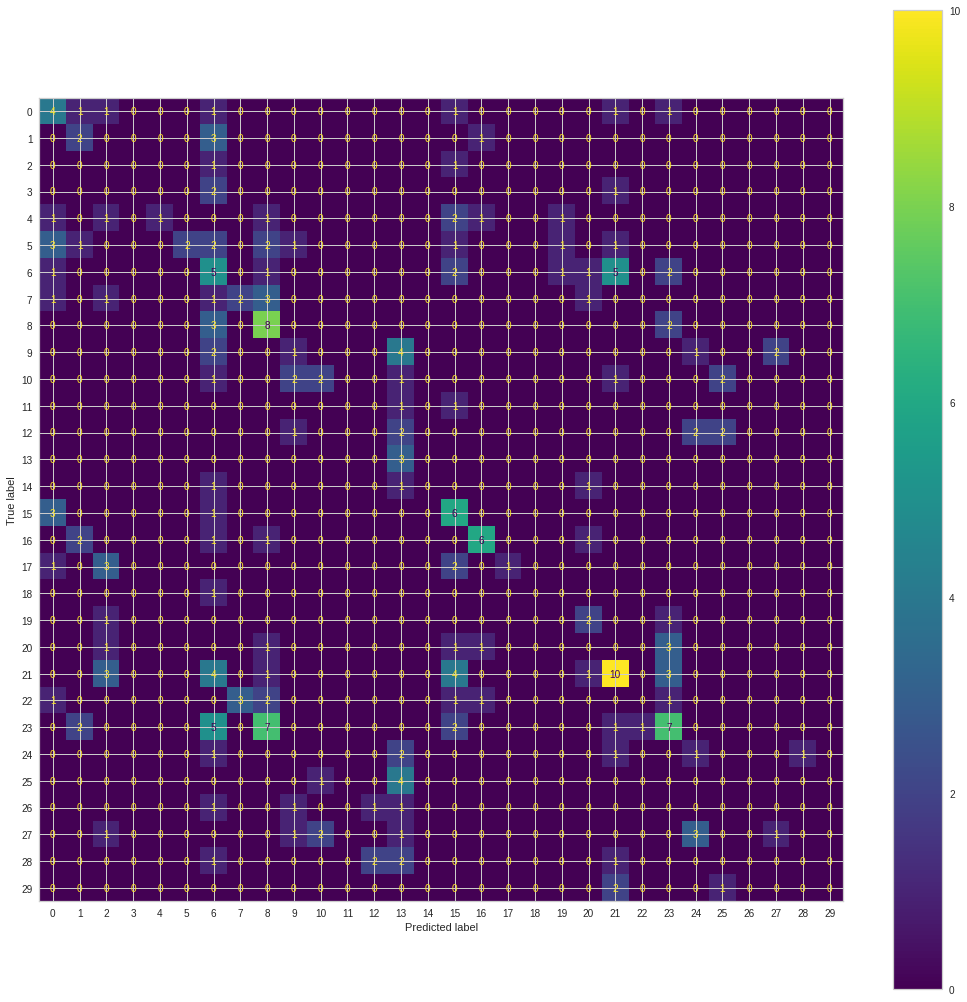

In [57]:
model_knn = KNeighborsClassifier(n_neighbors=30, weights='distance')

# Treinando o modelo
model_knn.fit(X_train, y_train)

# Predição
y_pred = model_knn.predict(X_test)

# Resultados do classificador
print(classification_report(y_test, y_pred))

plot_confusion_matrix(model_knn, X_test, y_test)


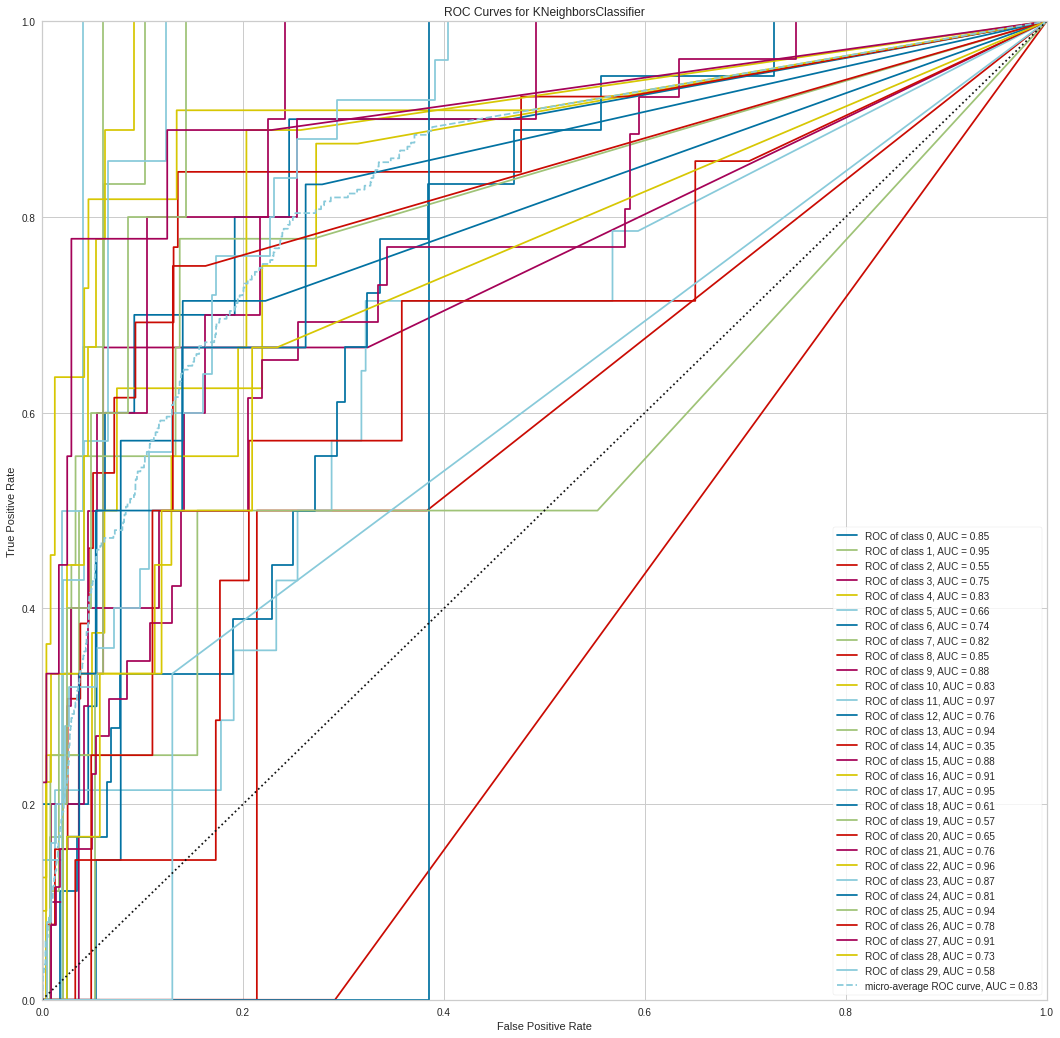

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [54]:
# Visualiza curvas ROC para cada parâmetro (one-vs-all)
visualizer = ROCAUC(model_knn, micro=True, macro=False)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

## Decision Trees

In [62]:
# cross validation + gridsearch
parameters = {'min_samples_split': [10, 20, 30],
              'max_depth':[5, 10, 20, 50],
              'max_features':[5, 10, 15, 20]
             }
grid_search(StratifiedKFold(n_splits=10, random_state=default_seed, shuffle=True), DecisionTreeClassifier(), parameters, X_train, y_train)

Melhor parametro: {'max_depth': 50, 'max_features': 20, 'min_samples_split': 20}
Fold 0: 0.133
Melhor parametro: {'max_depth': 10, 'max_features': 10, 'min_samples_split': 20}
Fold 1: 0.160
Melhor parametro: {'max_depth': 20, 'max_features': 20, 'min_samples_split': 20}
Fold 2: 0.187
Melhor parametro: {'max_depth': 10, 'max_features': 15, 'min_samples_split': 30}
Fold 3: 0.173
Melhor parametro: {'max_depth': 10, 'max_features': 10, 'min_samples_split': 20}
Fold 4: 0.173
Melhor parametro: {'max_depth': 10, 'max_features': 15, 'min_samples_split': 30}
Fold 5: 0.147
Melhor parametro: {'max_depth': 10, 'max_features': 20, 'min_samples_split': 20}
Fold 6: 0.187
Melhor parametro: {'max_depth': 10, 'max_features': 5, 'min_samples_split': 20}
Fold 7: 0.120
Melhor parametro: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 20}
Fold 8: 0.107
Melhor parametro: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 20}
Fold 9: 0.187

Acurácia média (desvio) : 0.157 +- (0.028)
Melhore

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002442,0.000079,0.000870,0.000056,5,5,10,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.118519,0.192593,0.133333,0.162963,0.125926,0.146667,0.027477,42
1,0.002410,0.000056,0.000885,0.000081,5,5,20,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.185185,0.162963,0.111111,0.125926,0.133333,0.143704,0.026749,44
2,0.002414,0.000245,0.000864,0.000043,5,5,30,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.125926,0.185185,0.162963,0.155556,0.148148,0.155556,0.019316,34
3,0.003569,0.000188,0.000877,0.000049,5,10,10,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.140741,0.170370,0.200000,0.148148,0.125926,0.157037,0.025831,32
4,0.003647,0.000326,0.000931,0.000105,5,10,20,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.096296,0.185185,0.155556,0.118519,0.125926,0.136296,0.030934,46
5,0.003373,0.000112,0.000854,0.000041,5,10,30,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.103704,0.170370,0.177778,0.162963,0.133333,0.149630,0.027477,40
6,0.004536,0.000078,0.000929,0.000119,5,15,10,"{'max_depth': 5, 'max_features': 15, 'min_samp...",0.162963,0.207407,0.207407,0.162963,0.140741,0.176296,0.026667,15
7,0.004537,0.000108,0.000916,0.000075,5,15,20,"{'max_depth': 5, 'max_features': 15, 'min_samp...",0.155556,0.207407,0.192593,0.133333,0.111111,0.160000,0.035863,30
8,0.004450,0.000289,0.000855,0.000032,5,15,30,"{'max_depth': 5, 'max_features': 15, 'min_samp...",0.170370,0.192593,0.214815,0.185185,0.140741,0.180741,0.024612,8
9,0.005649,0.000079,0.001171,0.000109,5,20,10,"{'max_depth': 5, 'max_features': 20, 'min_samp...",0.162963,0.207407,0.207407,0.162963,0.140741,0.176296,0.026667,15


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.14      0.17      0.15         6
           2       0.12      0.50      0.20         2
           3       0.00      0.00      0.00         3
           4       0.25      0.25      0.25         8
           5       0.00      0.00      0.00        14
           6       0.10      0.17      0.13        18
           7       1.00      0.11      0.20         9
           8       0.23      0.46      0.31        13
           9       0.17      0.10      0.12        10
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         2
          12       0.18      0.29      0.22         7
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       0.17      0.30      0.21        10
          16       0.33      0.27      0.30        11
          17       0.50    

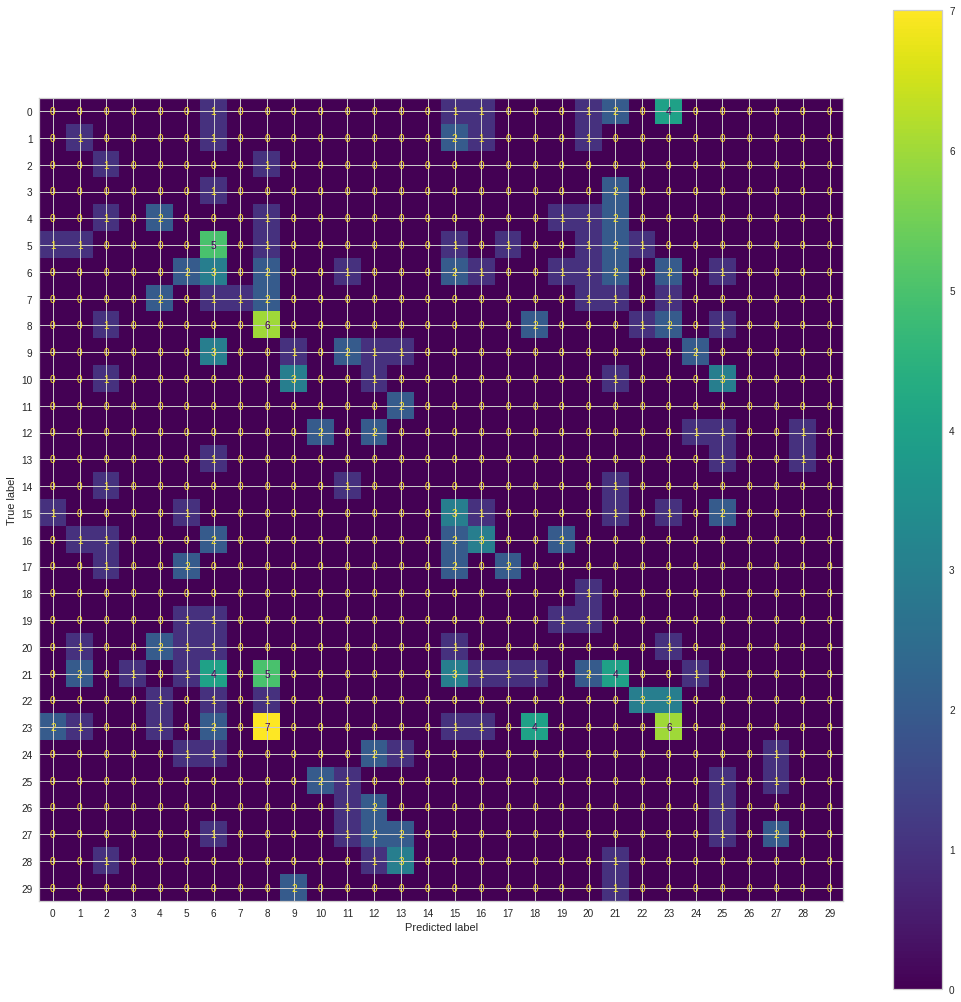

In [63]:
model_dt = DecisionTreeClassifier(max_depth=50, max_features=10, min_samples_split=20)

# Treinando o modelo
model_dt.fit(X_train, y_train)

# Predição
y_pred = model_dt.predict(X_test)

# Resultados do classificador
print(classification_report(y_test, y_pred))

plot_confusion_matrix(model_dt, X_test, y_test)


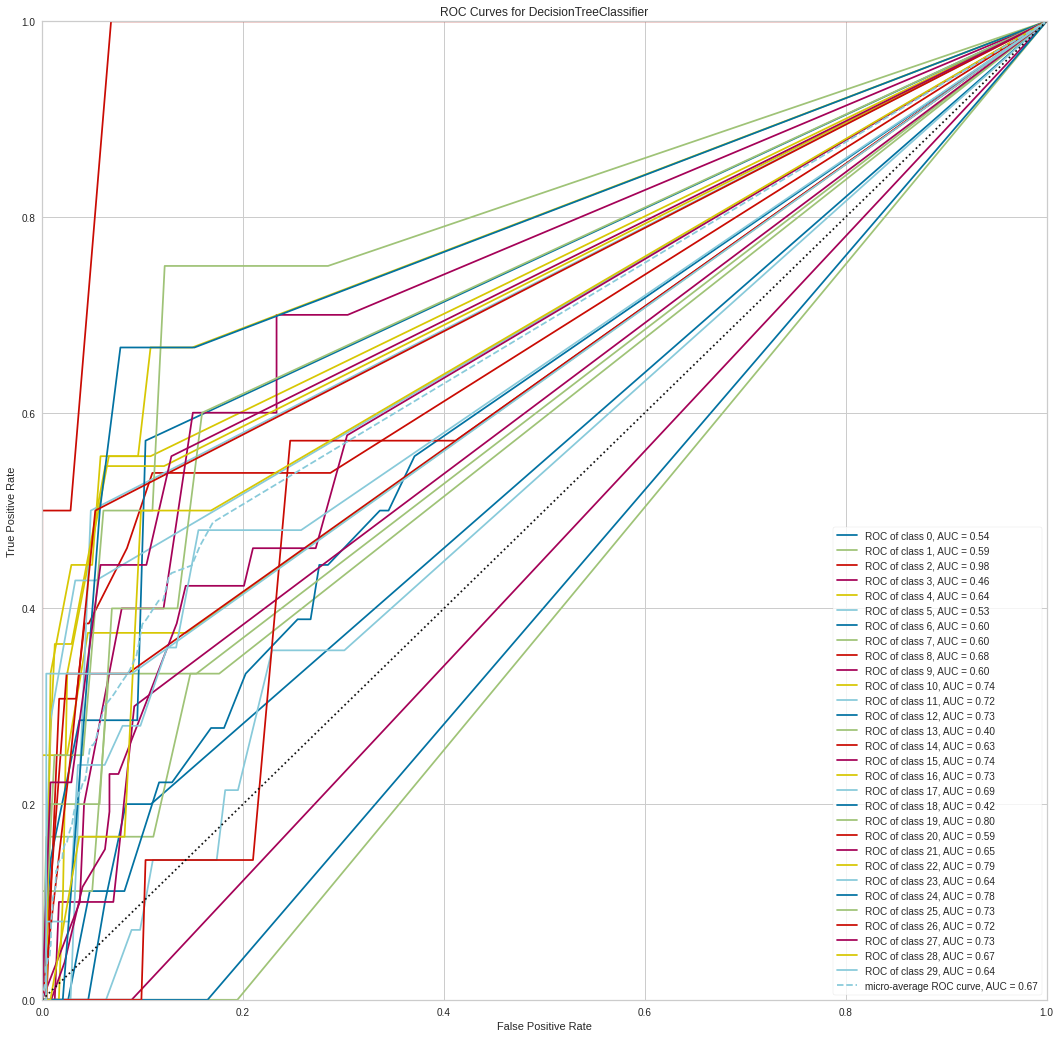

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [64]:
# Visualiza curvas ROC para cada parâmetro (one-vs-all)
visualizer = ROCAUC(model_dt, micro=True, macro=False)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

### Naïve Bayes

In [ ]:
# cross validation + gridsearch
parameters = {'min_samples_split': [10, 20, 30],
              'max_depth':[5, 10, 20, 50],
              'max_features':[5, 10, 15, 20]
             }
grid_search(StratifiedKFold(n_splits=10, random_state=default_seed, shuffle=True), MultinomialNB(), parameters, X_train, y_train)

Melhor parametro: {'max_depth': 50, 'max_features': 20, 'min_samples_split': 20}
Fold 0: 0.133
Melhor parametro: {'max_depth': 10, 'max_features': 10, 'min_samples_split': 20}
Fold 1: 0.160
Melhor parametro: {'max_depth': 20, 'max_features': 20, 'min_samples_split': 20}
Fold 2: 0.187
Melhor parametro: {'max_depth': 10, 'max_features': 15, 'min_samples_split': 30}
Fold 3: 0.173
Melhor parametro: {'max_depth': 10, 'max_features': 10, 'min_samples_split': 20}
Fold 4: 0.173
Melhor parametro: {'max_depth': 10, 'max_features': 15, 'min_samples_split': 30}
Fold 5: 0.147
Melhor parametro: {'max_depth': 10, 'max_features': 20, 'min_samples_split': 20}
Fold 6: 0.187
Melhor parametro: {'max_depth': 10, 'max_features': 5, 'min_samples_split': 20}
Fold 7: 0.120
Melhor parametro: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 20}
Fold 8: 0.107
Melhor parametro: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 20}
Fold 9: 0.187

Acurácia média (desvio) : 0.157 +- (0.028)
Melhore

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002442,0.000079,0.000870,0.000056,5,5,10,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.118519,0.192593,0.133333,0.162963,0.125926,0.146667,0.027477,42
1,0.002410,0.000056,0.000885,0.000081,5,5,20,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.185185,0.162963,0.111111,0.125926,0.133333,0.143704,0.026749,44
2,0.002414,0.000245,0.000864,0.000043,5,5,30,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.125926,0.185185,0.162963,0.155556,0.148148,0.155556,0.019316,34
3,0.003569,0.000188,0.000877,0.000049,5,10,10,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.140741,0.170370,0.200000,0.148148,0.125926,0.157037,0.025831,32
4,0.003647,0.000326,0.000931,0.000105,5,10,20,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.096296,0.185185,0.155556,0.118519,0.125926,0.136296,0.030934,46
5,0.003373,0.000112,0.000854,0.000041,5,10,30,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.103704,0.170370,0.177778,0.162963,0.133333,0.149630,0.027477,40
6,0.004536,0.000078,0.000929,0.000119,5,15,10,"{'max_depth': 5, 'max_features': 15, 'min_samp...",0.162963,0.207407,0.207407,0.162963,0.140741,0.176296,0.026667,15
7,0.004537,0.000108,0.000916,0.000075,5,15,20,"{'max_depth': 5, 'max_features': 15, 'min_samp...",0.155556,0.207407,0.192593,0.133333,0.111111,0.160000,0.035863,30
8,0.004450,0.000289,0.000855,0.000032,5,15,30,"{'max_depth': 5, 'max_features': 15, 'min_samp...",0.170370,0.192593,0.214815,0.185185,0.140741,0.180741,0.024612,8
9,0.005649,0.000079,0.001171,0.000109,5,20,10,"{'max_depth': 5, 'max_features': 20, 'min_samp...",0.162963,0.207407,0.207407,0.162963,0.140741,0.176296,0.026667,15


              precision    recall  f1-score   support

           0       0.25      0.30      0.27        10
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       1.00      0.38      0.55         8
           5       0.17      0.14      0.15        14
           6       0.14      0.28      0.19        18
           7       0.67      0.22      0.33         9
           8       0.13      0.62      0.21        13
           9       0.50      0.10      0.17        10
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         2
          12       0.11      0.14      0.12         7
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       0.12      0.10      0.11        10
          16       0.00      0.00      0.00        11
          17       0.00    

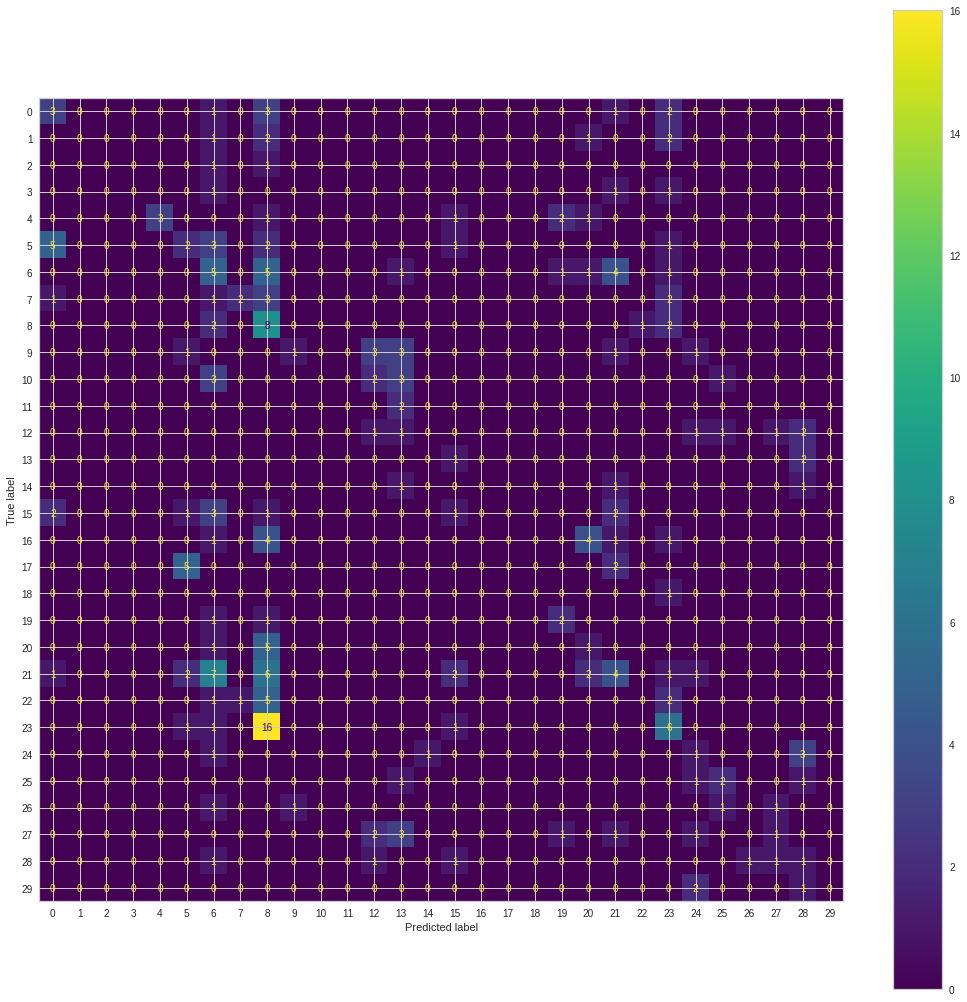

In [50]:
model_nb = MultinomialNB()

# Treinando o modelo
model_nb.fit(X_train, y_train)

# Predição
y_pred = model_nb.predict(X_test)

# Resultados do classificador
print(classification_report(y_test, y_pred))

plot_confusion_matrix(model_nb, X_test, y_test)
